In [ ]:
!pip install torch torchvision torchaudio
!pip install gymnasium==0.29.1
!pip install minatar==1.0.15
!pip install matplotlib
!pip install imageio

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from typing import Iterable


import copy
import numpy as np
import pandas as pd
import random
from PIL import Image
import gymnasium as gym
import matplotlib.pyplot as plt
from typing import Callable
from collections import namedtuple
import itertools

In [2]:
class DQN(nn.Module):
    def __init__(self, obs_shape: torch.Size, num_actions: int):

        super(DQN, self).__init__()
        
        self.register_buffer("action_num", torch.tensor(num_actions, dtype=torch.int))

        self.conv1 = nn.Conv2d(obs_shape[-1], 16, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride = 1)
        self.linear1 = nn.Linear(32*4*4, 128)
        self.linear2 = nn.Linear(128, num_actions)
        
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:            
        x = x.permute(0, 3, 1, 2)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = torch.flatten(x,1)
        x = self.relu(self.linear1(x))
        q_value = self.linear2(x)
        return q_value

In [3]:
class Duelling_DQN(nn.Module):
    def __init__(self, obs_shape: torch.Size, num_actions: int):

        super(Duelling_DQN, self).__init__()

        self.register_buffer("action_num", torch.tensor(num_actions, dtype=torch.int))

        self.conv1 = nn.Conv2d(obs_shape[-1], 16, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride = 1)

        self.linear = nn.Linear(32*6*6, 512)

        self.value = nn.Linear(512, 1)
        self.advantage = nn.Linear(512, num_actions)

        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0, 3, 1, 2)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = torch.flatten(x,1)
        x = self.relu(self.linear(x))

        value = self.value(x)
        advantage = self.advantage(x)

        q_value = value + advantage - torch.sum(advantage)/self.action_num

        return q_value

In [4]:
def make_epsilon_greedy_policy(Q: nn.Module, num_actions: int):
    def policy_fn(obs: torch.Tensor, epsilon: float = 0.0):
        """This function takes in the observation and returns an action."""
        if np.random.uniform() < epsilon:
            return np.random.randint(0, num_actions)
        
        # For action selection, we do not need a gradient and so we call ".detach()"
        return Q(obs).argmax().detach().numpy()

    return policy_fn

In [5]:
def linear_epsilon_decay(eps_start: float, eps_end: float, current_timestep: int, duration: int) -> float:
    # TODO: your code
    ratio = min(1.0, current_timestep / duration)
    return (eps_start - eps_end) * (1 - ratio) + eps_end

In [6]:
class ReplayBuffer:
    def __init__(self, max_size: int):
        self.data = []
        self.max_size = max_size
        self.position = 0

    def __len__(self) -> int:
        return len(self.data)

    def store(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor, next_obs: torch.Tensor, terminated: torch.Tensor):
        if len(self.data) < self.max_size:
            self.data.append((obs, action, reward, next_obs, terminated))
        else:
            self.data[self.position] = (obs, action, reward, next_obs, terminated)   
        self.position = (self.position + 1) % self.max_size         

    def sample(self, batch_size: int) -> torch.Tensor:
        return [torch.stack(b) for b in zip(*random.choices(self.data, k=batch_size))]

In [7]:
def update_dqn(
        q: nn.Module,
        q_target: nn.Module,
        optimizer: optim.Optimizer,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
    ):

    optimizer.zero_grad()

    with torch.no_grad():
        td_target = rew + gamma * q_target(next_obs).max(dim=1)[0] * (1 - tm.float())

    loss = F.mse_loss(q(obs).gather(1, act.unsqueeze(1)), td_target.unsqueeze(1))

    loss.backward()
    optimizer.step()


In [8]:
def polyak_update(
    params: Iterable[torch.Tensor],
    target_params: Iterable[torch.Tensor],
    tau: float,
) -> None:
    for param, target_param in zip(params, target_params):
        target_param.data.mul_(1 - tau)
        target_param.data.add_(param.data * tau)

In [9]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])

class DQNAgent:
    def __init__(self,
            env,
            gamma=0.99,
            lr=0.001, 
            batch_size=64,
            eps_start=1.0,
            eps_end=0.1,
            schedule_duration=10_000,
            tau=0.005,
            maxlen=100_000,
        ):

        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.schedule_duration = schedule_duration
        self.tau = tau

        self.buffer = ReplayBuffer(maxlen)
        self.q = DQN(env.observation_space.shape, env.action_space.n)
        self.q_target = DQN(env.observation_space.shape, env.action_space.n)
        self.q_target.load_state_dict(self.q.state_dict())
        self.optimizer = optim.Adam(self.q.parameters(), lr=lr)
        self.policy = make_epsilon_greedy_policy(self.q, env.action_space.n)


    def train(self, num_episodes: int) -> EpisodeStats:
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
        )
        current_timestep = 0
        epsilon = self.eps_start

        for i_episode in range(num_episodes):
            if (i_episode + 1) % 100 == 0:
                print(f'Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}  Epsilon: {epsilon:.3f}')

            obs, _ = self.env.reset()
            
            for episode_time in itertools.count():
                epsilon = linear_epsilon_decay(self.eps_start, self.eps_end, current_timestep, self.schedule_duration)

                action = self.policy(torch.as_tensor(obs).unsqueeze(0).float(), epsilon=epsilon)
                next_obs, reward, terminated, truncated, _ = self.env.step(action)

                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                self.buffer.store(
                    torch.as_tensor(obs, dtype=torch.float32),
                    torch.as_tensor(action),
                    torch.as_tensor(reward, dtype=torch.float32),
                    torch.as_tensor(next_obs, dtype=torch.float32),
                    torch.as_tensor(terminated)
                )

                obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch = self.buffer.sample(self.batch_size)
                
                update_dqn(
                    self.q,
                    self.q_target,
                    self.optimizer,
                    self.gamma, 
                    obs_batch.float(),
                    act_batch, 
                    rew_batch.float(),
                    next_obs_batch.float(),
                    tm_batch
                )

                polyak_update(self.q.parameters(), self.q_target.parameters(), self.tau)
                current_timestep += 1

                if terminated or truncated or episode_time >= 500:
                    break
                obs = next_obs
        return stats

In [10]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])

class Duelling_DQNAgent:
    def __init__(self,
            env,
            gamma=0.99,
            lr=0.001, 
            batch_size=64,
            eps_start=1.0,
            eps_end=0.1,
            schedule_duration=10_000,
            tau=0.005,
            maxlen=100_000,
        ):

        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.schedule_duration = schedule_duration
        self.tau = tau

        self.buffer = ReplayBuffer(maxlen)
        self.q = Duelling_DQN(env.observation_space.shape, env.action_space.n)
        self.q_target = Duelling_DQN(env.observation_space.shape, env.action_space.n)
        self.q_target.load_state_dict(self.q.state_dict())
        self.optimizer = optim.Adam(self.q.parameters(), lr=lr)
        self.policy = make_epsilon_greedy_policy(self.q, env.action_space.n)

    def train(self, num_episodes: int) -> EpisodeStats:
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
        )
        current_timestep = 0
        epsilon = self.eps_start

        for i_episode in range(num_episodes):
            if (i_episode + 1) % 100 == 0:
                print(f'Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}  Epsilon: {epsilon:.3f}')

            obs, _ = self.env.reset()
            
            for episode_time in itertools.count():
                epsilon = linear_epsilon_decay(self.eps_start, self.eps_end, current_timestep, self.schedule_duration)

                action = self.policy(torch.as_tensor(obs).unsqueeze(0).float(), epsilon=epsilon)
                next_obs, reward, terminated, truncated, _ = self.env.step(action)

                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                self.buffer.store(
                    torch.as_tensor(obs, dtype=torch.float32),
                    torch.as_tensor(action),
                    torch.as_tensor(reward, dtype=torch.float32),
                    torch.as_tensor(next_obs, dtype=torch.float32),
                    torch.as_tensor(terminated)
                )

                obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch = self.buffer.sample(self.batch_size)
                
                update_dqn(
                    self.q,
                    self.q_target,
                    self.optimizer,
                    self.gamma, 
                    obs_batch.float(),
                    act_batch, 
                    rew_batch.float(),
                    next_obs_batch.float(),
                    tm_batch
                )

                polyak_update(self.q.parameters(), self.q_target.parameters(), self.tau)
                current_timestep += 1

                if terminated or truncated or episode_time >= 500:
                    break
                obs = next_obs
        return stats

In [12]:
env = gym.make('MinAtar/SpaceInvaders-v1', render_mode="rgb_array")

print(f"Training on {env.spec.id}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}\n")

LR = 0.001
BATCH_SIZE = 16
REPLAY_BUFFER_SIZE = 100_000
TAU = 0.005
EPS_START = 0.5
EPS_END = 0.05
SCHEDULE_DURATION = 50_000
NUM_EPISODES = 1_000
DISCOUNT_FACTOR = 0.99

# Train DQN
agent_dqn = DQNAgent(
    env, 
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    tau=TAU,
    maxlen=REPLAY_BUFFER_SIZE,
)
stats_dqn = agent_dqn.train(NUM_EPISODES)


# Train Duelling_DQN
agent_simple = Duelling_DQNAgent(
    env, 
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    tau=TAU,
    maxlen=REPLAY_BUFFER_SIZE,
)
stats_duelling_dqn = agent_simple.train(NUM_EPISODES)


Training on MinAtar/SpaceInvaders-v1
Observation space: Box(False, True, (10, 10, 6), bool)
Action space: Discrete(4)

Episode 100 of 1000  Time Step: 6120  Epsilon: 0.445
Episode 200 of 1000  Time Step: 16213  Epsilon: 0.354
Episode 300 of 1000  Time Step: 29644  Epsilon: 0.233
Episode 400 of 1000  Time Step: 43951  Epsilon: 0.104
Episode 500 of 1000  Time Step: 62062  Epsilon: 0.050
Episode 600 of 1000  Time Step: 81159  Epsilon: 0.050
Episode 700 of 1000  Time Step: 97754  Epsilon: 0.050
Episode 800 of 1000  Time Step: 111228  Epsilon: 0.050
Episode 900 of 1000  Time Step: 124832  Epsilon: 0.050
Episode 1000 of 1000  Time Step: 138282  Epsilon: 0.050
Episode 100 of 1000  Time Step: 5198  Epsilon: 0.453
Episode 200 of 1000  Time Step: 14414  Epsilon: 0.370
Episode 300 of 1000  Time Step: 26510  Epsilon: 0.261
Episode 400 of 1000  Time Step: 43670  Epsilon: 0.107
Episode 500 of 1000  Time Step: 64866  Epsilon: 0.050
Episode 600 of 1000  Time Step: 84187  Epsilon: 0.050
Episode 700 of 

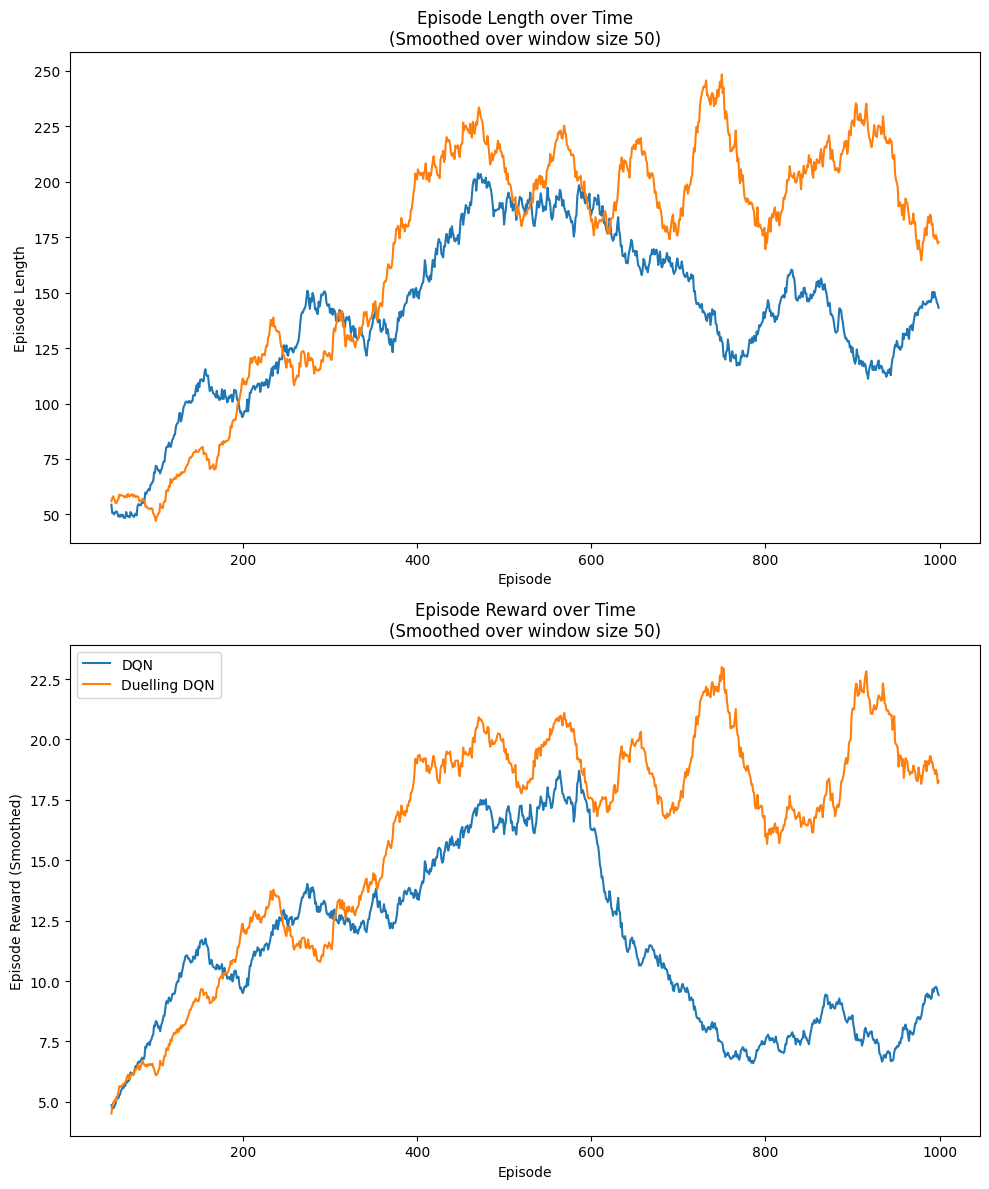

In [16]:
smoothing_window=50
fig, axes = plt.subplots(2, 1, figsize=(10, 12), tight_layout=True)

# Plot the episode length over time
ax = axes[0]
lengths_smoothed_dqn = pd.Series(stats_dqn.episode_lengths).rolling(smoothing_window, min_periods=smoothing_window).mean()
lengths_smoothed_duelling = pd.Series(stats_duelling_dqn.episode_lengths).rolling(smoothing_window, min_periods=smoothing_window).mean()
ax.plot(lengths_smoothed_dqn)
ax.plot(lengths_smoothed_duelling)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Length")
ax.set_title(f"Episode Length over Time\n(Smoothed over window size {smoothing_window})")

# Plot the episode reward over time
ax = axes[1]
rewards_smoothed_dqn = pd.Series(stats_dqn.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
rewards_smoothed_duelling = pd.Series(stats_duelling_dqn.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
ax.plot(rewards_smoothed_dqn, label="DQN")
ax.plot(rewards_smoothed_duelling, label="Duelling DQN")
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Reward (Smoothed)")
ax.set_title(f"Episode Reward over Time\n(Smoothed over window size {smoothing_window})")
plt.legend() 
plt.show()

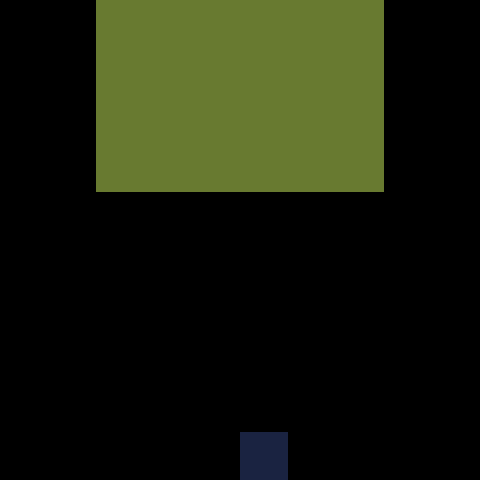

In [18]:
from IPython.display import Image as IImage

def save_rgb_animation(rgb_arrays, filename, duration=50):
    """Save an animated GIF from a list of RGB arrays."""
    # Create a list to hold each frame
    frames = []

    # Convert RGB arrays to PIL Image objects
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array*255).astype(np.uint8)
        rgb_array = rgb_array.repeat(48, axis=0).repeat(48, axis=1)
        img = Image.fromarray(rgb_array)
        frames.append(img)

    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(policy, env, max_steps=1_000):
    """Rollout for one episode while saving all rendered images."""
    obs, _ = env.reset()
    imgs = [env.render()]

    for _ in range(max_steps):
        action = policy(torch.as_tensor(obs, dtype=torch.float32).unsqueeze(0))
        obs, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())
        
        if terminated or truncated:
            break

    return imgs

policy = make_epsilon_greedy_policy(agent_simple.q, num_actions=env.action_space.n)
imgs = rendered_rollout(policy, env)
save_rgb_animation(imgs, "trained_duelling_simple.gif")
IImage(filename="trained_duelling_simple.gif")